# Picca Tutorial 1 : continuum fitting

By Julian Bautista 

This notebook is an interactive version of `$PICCA_BASE/bin/picca_deltas.py`, 
which is the code that fits the continua of Lyman-alpha forests.

How to use PICCA on NERSC: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/Picca_at_NERSC

We assume that you have picca installed and access to the eBOSS spectra and the quasar catalog.
This notebook has been run on NERSC at the following folder, so you can copy the relevant files:

`/global/project/projectdirs/desi/users/bautista/lya/DR16_tutorial`

Here is the table of contents of this tutorial.

1) Importing libraries and setting up wavelength ranges

2) Reading the spectra

3) Looking closer at one forest

4) Plotting some sample properties

5) Adding masks

6) Adding DLAs

7) Removing short forests

8) Continuum fitting and plotting average quantities

For more information on how to run Jupyter notebooks @ NERSC:

https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC


In [1]:
import numpy as np
import pylab as plt
import os

from astropy.table import Table

from picca.data import Forest, Delta
from picca.dla import DLA
from picca import prep_del, io, constants


## 1) Defining wavelength ranges 

Here we define the wavelength ranges used in our analysis, both in observer-frame and rest-frame. These wavelengths also define the minimum and maximum quasar redshifts. 

In eBOSS, the spectral wavelengths are given in log-space. So throughout the analysis, we use $\log_{10}(\lambda)$. The original wavelength grid of eBOSS spectra are bins of $\Delta \log_{10}(\lambda) = \Delta \lambda/\lambda = 10^{-4}$.

We re-bin original spectral bins into larger "analysis" bins. As in the DR16 analysis, we rebin 3 original pixels into one analysis pixel, using inverse variance weighting.

In [3]:
#-- Observer-frame 
lambda_min = 3600.
lambda_max = 5500.
Forest.log_lambda_min = np.log10(lambda_min)
Forest.log_lambda_max = np.log10(lambda_max)

#-- Rest-frame : Lyman-alpha forest 
lambda_rest_min = 1040.
lambda_rest_max = 1200.
Forest.log_lambda_min_rest_frame = np.log10(lambda_rest_min)
Forest.log_lambda_max_rest_frame = np.log10(lambda_rest_max)

#-- Rebin 3 native pixels into one
rebin = 3
Forest.rebin = rebin
Forest.delta_log_lambda = rebin * 1e-4

#-- Minimum and maximum redshifts of quasars
zqso_min = lambda_min / lambda_rest_max - 1.
zqso_max = lambda_max / lambda_rest_min - 1.

print(f'zqso_min = {zqso_min:.3f}')
print(f'zqso_max = {zqso_max:.3f}')

zqso_min = 2.000
zqso_max = 4.288


## 2) Reading the spectra

In this exercise, we are reading eBOSS spectra using the 'spplate' format (files named spPlate-PLATE-MJD.fits). 

The standard analysis co-adds multiple observations of a given quasar. 
In this configuration. the spAll file gives the information about the multiple PLATE-MJD-FIBERID for a given quasar. They are co-added by the function picca.io.read_data(). If you want to use only the best-observation, the spAll file is not needed.

This function reads the data and organises it into a dictionary where 
- its keys are healpix ids 
- its values are a list/array of picca.data.Forest objects.

In [4]:

#-- Type of input spectra files: pix, spec, spcframe, spplate, desi
mode = 'spplate'

folder_with_data = '/global/projecta/projectdirs/sdss/data/sdss/dr16/eboss/spectro/redux/v5_13_0'

#-- I created a small version of the catalog containing only the Stripe 82
path_to_quasar_catalog = 'Catalogs/DR16Q_v2_S82.fits'
#-- I created a small version of the spAll file containing only quasars 
path_to_spall = 'Catalogs/spAll-v5_13_0-DR16Q_v2.fits'

#-- For testing purposes, it is useful to read just a few forests
#-- Setting it to None will read all spectra
max_number_of_spectra = None
#-- For spplate and sp
use_only_best_exposure = False

(data, num_data, nside,
     healpy_pix_ordering) = io.read_data(folder_with_data,
                                         path_to_quasar_catalog,
                                         mode,
                                         z_min = zqso_min,
                                         z_max = zqso_max,
                                         max_num_spec = max_number_of_spectra,
                                         best_obs = use_only_best_exposure,
                                         spall = path_to_spall)

mode: spplate

 start                 : nb object in cat = 39137
 and thingid > 0       : nb object in cat = 38647
 and ra != dec         : nb object in cat = 38647
 and ra != 0.          : nb object in cat = 38647
 and dec != 0.         : nb object in cat = 38647
 and z > 0.            : nb object in cat = 38647
 and z >= z_min        : nb object in cat= 12278
 and z < z_max         : nb object in cat= 12164
BAL_FLAG_VI not found


determining nside
nside = 4 -- mean #obj per pixel = 760.25
INFO: reading spAll from Catalogs/spAll-v5_13_0-DR16Q_v2.fits
INFO: Found 20045 spectra with required THING_ID
INFO: Found 20045 spectra with 'good' plate
INFO: Found 20045 spectra without 0 bit set: SKY
INFO: Found 19972 spectra without 1 bit set: LITTLE_COVERAGE
INFO: Found 19970 spectra without 7 bit set: UNPLUGGED
INFO: Found 19970 spectra without 8 bit set: BAD_TARGET
INFO: Found 19970 spectra without 9 bit set: NODATA
INFO: # unique objs:  12164
INFO: # spectra:  19970
reading 380 plates
INFO

## 3) Looking closer at one forest

Before continuum fitting, let's inspect some of the data and understand some of its properties.

Below, we plot the flux $f_q(\lambda)$ of quasar $q$ as a function of observer-frame wavelength $\lambda$. The error of each flux estimate is given by $\sigma_{\rm pip, q}(\lambda)$. 


In [5]:
print('Number of forests:', num_data)
print('Healpix NSIDE value:', nside)
print('Healpix pixel ordering:', healpy_pix_ordering)
print('How many Healpix pixels have data:', len(data))

Number of forests: 11425
Healpix NSIDE value: 4
Healpix pixel ordering: RING
How many Healpix pixels have data: 13


In [6]:
#-- Let's get one forest first and print its metadata

pixels = list(data.keys())
forest = data[pixels[0]][4]

print(f'Quasar redshift {forest.z_qso}')
print(f'RA = {forest.ra} radians')
print(f'Dec = {forest.dec} radians')
print(f'THING_ID = {forest.thingid}')
print(f'plate-mjd-fiberid = {forest.plate}-{forest.mjd}-{forest.fiberid:04d}')
print(f'Average pixel signal-to-noise ratio: {forest.mean_snr}' )

Quasar redshift 2.641
RA = 0.15551853752930953 radians
Dec = -0.020576402908643134 radians
THING_ID = 68176969
plate-mjd-fiberid = 3586-55181-0044
Average pixel signal-to-noise ratio: 6.231375410289121


In [7]:
#-- Let's plot this forest's flux and errors

def plot_forest(forest):
    wave = 10**forest.log_lambda

    plt.figure()
    plt.plot(wave, forest.flux, color='C0')
    plt.axhline(0, color='k', ls=':', alpha=0.3)
    plt.ylabel(r'$f_q(\lambda)$ [$10^{-17}$ erg $s^{-1}$ $cm^{-2}$ $\AA^{-1}$]', fontsize=12)
    plt.xlabel(r'Observer-frame wavelength [$\AA$]', fontsize=12)

    plt.figure()
    w = forest.ivar > 0
    error = 1/np.sqrt(forest.ivar[w])
    plt.plot(wave[w], error, color='C1')
    plt.axhline(0, color='k', ls=':', alpha=0.3)
    plt.ylabel(r'$\sigma_{\rm pip, q}$ [$10^{-17}$ erg $s^{-1}$ $cm^{-2}$ $\AA^{-1}$]', fontsize=12)
    plt.xlabel(r'Observer-frame wavelength [$\AA$]', fontsize=12)


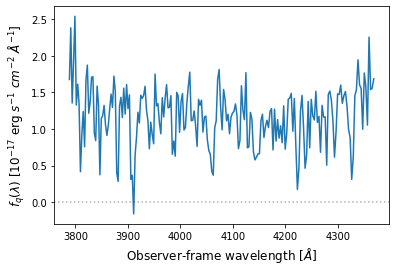

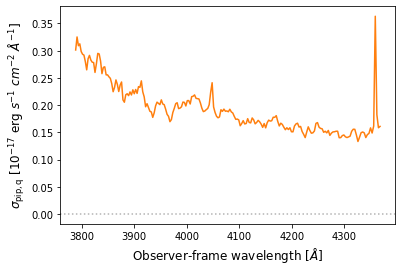

In [8]:
plot_forest(forest)

## 4) Overall properties of the sample

In [9]:
def get_metadata(data):
    ''' Constructs an astropy.table from all forests' metadata 
    '''
    tab = Table()
    for field in ['ra', 'dec', 'z_qso', 'thingid', 'plate', 'mjd', 'fiberid', 'mean_snr', 'p0', 'p1']:
        x = []
        for healpix in data:
            for forest in data[healpix]:
                if field in forest.__dict__ and not forest.__dict__[field] is None:
                    x.append(forest.__dict__[field])
                else:
                    x.append(0)
        tab[field] = np.array(x)

    npix = []
    for healpix in data:
        for forest in data[healpix]:
            if forest.log_lambda is None:
                npix.append(0)
            else:
                npix.append(forest.log_lambda.size)
    tab['npixels'] = np.array(npix)
    
    return tab

In [10]:
tab = get_metadata(data)

In [11]:
tab

ra,dec,z_qso,thingid,plate,mjd,fiberid,mean_snr,p0,p1,npixels
float64,float64,float64,int32,int32,int32,int32,float64,int64,int64,int64
0.1630098637531836,-0.006419137488161887,2.242,87772478,3586,55181,16,4.713732840071453,0,0,113
0.16489220799855364,0.0005477111755351545,2.259,96734163,3586,55181,18,3.4548094259212214,0,0,120
0.16528765112626811,0.0004271442591052744,3.181,96735175,3586,55181,20,5.031636446236026,0,0,207
0.16083625105312344,-0.002894901959922181,2.196,94651795,3586,55181,38,2.742596202635748,0,0,92
0.15551853752930953,-0.020576402908643134,2.641,68176969,3586,55181,44,6.231375410289121,0,0,207
0.16089015531009593,-0.01424015912980978,2.658,77739381,3586,55181,52,21.286503438786344,0,0,208
0.15844981167656128,-0.013525986544463051,4.04,77738469,3586,55181,56,25.87165354138354,0,0,70
0.15645040019380396,-0.0013505566966317696,2.823,94652416,3586,55181,76,11.841816903737795,0,0,207
0.15734157544205168,0.0012766402399323898,2.251,96731656,3586,55181,80,16.098270457583883,0,0,117


Text(0.5, 1.0, 'Stripe 82 QSOs')

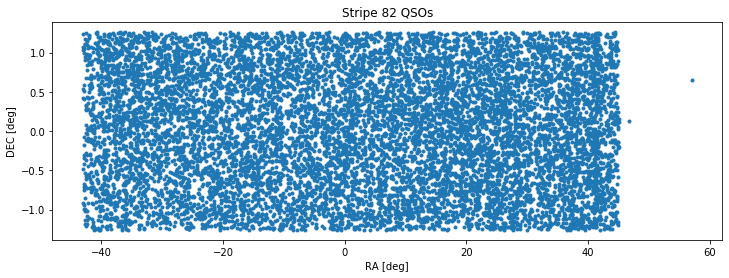

In [12]:
plt.figure(figsize=(12,4))
ra = np.degrees(tab['ra'])
dec = np.degrees(tab['dec'])
plt.plot(ra-360*(ra>300), dec, '.')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.title('Stripe 82 QSOs')

Text(0.5, 0, 'Mean pixel S/N')

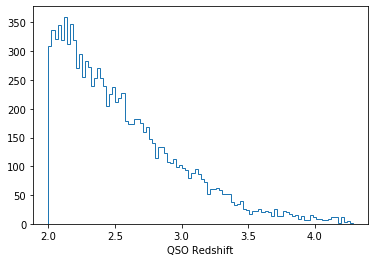

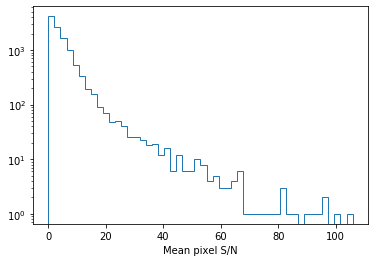

In [13]:
plt.figure()
plt.hist(tab['z_qso'], bins=100, histtype='step')
plt.xlabel('QSO Redshift')

plt.figure()
w = tab['mean_snr'] > 0
plt.hist(tab['mean_snr'][w], bins=50, histtype='step')
plt.yscale('log')
plt.xlabel('Mean pixel S/N')

## 5) Masking pixels in the forest

Now we will apply several masks to the forest, such as the sky lines and Calcium H&K masks. 
The relevant wavelenghts are stored in the `dr16-line-sky-mask.txt` which will be added to the standard picca repository.


In [14]:
#- Read sky mask
sky_mask = Table.read('dr16-line-sky-mask.txt', names=('type', 'wave_min', 'wave_max', 'frame'), format='ascii')

In [15]:
sky_mask

type,wave_min,wave_max,frame
str4,float64,float64,str3
CaII,3930.1,3938.2,OBS
CaII,3965.5,3973.8,OBS
sky,4043.0,4051.3,OBS
sky,4353.1,4365.1,OBS
sky,5456.8,5467.3,OBS
sky,5570.5,5590.0,OBS
sky,5883.3,5903.3,OBS
sky,6294.8,6316.8,OBS


In [16]:
#-- Creating this array which is the format needed in picca.data.Forest.mask()
sky_mask_log_lambda = np.array([np.log10(sky_mask['wave_min']), np.log10(sky_mask['wave_max'])])
sky_mask_log_lambda_rest_frame = np.array([])

In [17]:
#-- Loop over forests and applying mask 
for healpix in data:
    for forest in data[healpix]:
        forest.mask(sky_mask_log_lambda, sky_mask_log_lambda_rest_frame)
        
tab_mask = get_metadata(data)

In [18]:
print(f"Total number of pixels before masking: {np.sum(tab['npixels'])}")
print(f"Total number of pixels after  masking: {np.sum(tab_mask['npixels'])}")
print(f"Total number of pixels masked: {np.sum(tab['npixels']- tab_mask['npixels'])}")

Total number of pixels before masking: 1678523
Total number of pixels after  masking: 1606528
Total number of pixels masked: 71995


## 6) Adding DLA information 

The Damped Lyman-Alpha (DLA) systems are strong absorption systems that can potentially interfere on the continuum fitting process.

In the standard analysis, we chose to mask pixels that would have more than 20% of their flux absorbed by the DLA (or equivalently where the DLA transmission is below 80%). 

The DLA information we need is : 
- an line-of-sight identifier (THING_ID or RA,DEC)
- the redshift of each absorber 
- the column density of each absorber in $cm^{-2}$

Given the redshift and the column density of an absorber, the picca.dla.DLA class computes the transmission of this DLA as a function of wavelength. 

In the following, we illustrate how the DLA class works, and then we apply the masking to the sample of forests.

Text(0, 0.5, 'DLA Transmission')

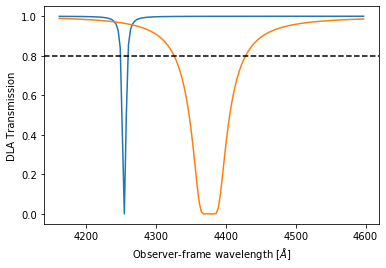

In [19]:
#-- Define first some DLA parameters
#-- Mask pixels around DLAs below 80% of DLA transmission
Forest.dla_mask_limit = 0.8
#-- Mask width on each side of the absorber central observed wavelength in units 1e-4 (log-wavelength)
Forest.absorber_mask_width = 2.5


#-- Let's first see how the DLA profiles look like
#-- The magic happens in picca.dla, so we create a fake forest to give the DLA class

log_lambda = np.arange(np.log10(3600), np.log10(4600), Forest.delta_log_lambda)
forest = Forest(log_lambda, np.ones_like(log_lambda), np.ones_like(log_lambda),
                0, 0, 0, 3., 0, 0, 0, 1)

#- z_dla = 2.5, log10(N_HI/cm^2) = 19.0
dla_example1 = DLA(forest, 2.5, 19.0)
#- z_dla = 2.6, log10(N_HI/cm^2) = 21.0
dla_example2 = DLA(forest, 2.6, 21.0)
plt.figure()
plt.plot(10**forest.log_lambda, dla_example1.transmission)
plt.plot(10**forest.log_lambda, dla_example2.transmission)
plt.axhline(Forest.dla_mask_limit, color='k', ls='--')
plt.xlabel(r'Observer-frame wavelength [$\AA$]')
plt.ylabel('DLA Transmission')

In [20]:
#-- Reads DLA information into a dictionary where 
#-- keys are THING_ID and 
#-- values are a list of (z_dla, log10(N_HI)) for this line-of-sight
dlas = io.read_dlas('Catalogs/cat_for_DLA_v2.fits')



 In catalog: 39514 DLAs
 In catalog: 35683 forests have a DLA




In [21]:

#-- Need to setup a random seed for the Voigt profile calculation
np.random.seed(0)

#-- Loop over forests masking central parts and correcting flux over DLA wings
#-- The magic happens in picca.dla 
num_dlas = 0
for healpix in data:
    for forest in data[healpix]:
        if forest.thingid in dlas:
            for dla in dlas[forest.thingid]:
                dla_z = dla[0]
                dla_nhi = dla[1]
                forest.add_dla(dla_z, dla_nhi)
                num_dlas += 1

In [22]:
tab_dla = get_metadata(data)

In [23]:
print(f"Total number of pixels before DLA masking: {np.sum(tab_mask['npixels'])}")
print(f"Total number of pixels after  DLA masking: {np.sum(tab_dla['npixels'])}")
print(f"Total number of pixels masked by DLA: {np.sum(tab_mask['npixels']- tab_dla['npixels'])}")

Total number of pixels before DLA masking: 1606528
Total number of pixels after  DLA masking: 1589145
Total number of pixels masked by DLA: 17383


## 7) Remove forests with no data, too short forests or too low S/N 

We remove forests that have no data (they have `loglam = None`) or forests with too few pixels (less than 50 is the standard values)

In [24]:
#-- Minimum number of valid pixels in a forest, 50 is the default in picca_deltas.py
npix_min = 50 
use_constant_weight = False

nforests_before = np.sum([len(forest) for forest in data.values()])

remove_keys = []
for healpix in data:
    forests = []
    for forest in data[healpix]:
        if ((forest.log_lambda is None) or
            len(forest.log_lambda) < npix_min):
            continue

        if np.isnan((forest.flux * forest.ivar).sum()):
            continue

        if (use_constant_weight and
            (forest.flux.mean() <= 0.0 or forest.mean_snr <= 1.0)):
            continue
            
        forests.append(forest)
        
    data[healpix][:] = forests
    
    if len(data[healpix]) == 0:
        remove_keys += [healpix]

    for healpix in remove_keys:
        del data[healpix]

nforests_after = np.sum([len(forest) for forest in data.values()])
print(f"Original  sample has {nforests_before} forests")
print(f"Remaining sample has {nforests_after} forests")

Original  sample has 11425 forests
Remaining sample has 9726 forests


## 8) Continuum fitting

This is the most important part: the continuum fitting procedure. From du Mas des Bourboux et al. 2020: 

"For each spectral region in each line-of-sight, the flux-transmission field, $\delta_q(\lambda)$, at the observed wavelength, $\lambda$, is obtained from the ratio of the observed flux, $f_q(\lambda)$, to the mean expected flux, $\bar{F}(z) C_q(\lambda)$:

$$\delta_q(\lambda) = \frac{f_q(\lambda)}{\bar{F}(z) C_q(\lambda)}$$

Here, $C_q(\lambda)$ is the unabsorbed quasar continuum and $F(\lambda)$ is the mean transmission. Their product is taken to be a universal function of $\lambda_{\rm RF}$ corrected by a first degree polynomial in $\log_{10}(\lambda)$:

$$\bar{F}(\lambda)C_q(\lambda) = \bar{C}(\lambda_{\rm RF}) (p_0 + p_1 \log_{10}(\lambda))$$

where $(p_0, p_1)$ are parameters fitted separately for the Ly$\alpha$ and Ly$\beta$ spectral regions of each line-of-sight by maximizing the likelihood function

$$ 2 \ln L = - \sum_i \frac{[f_i - \bar{F}C_q(\lambda_i, p_0, p_1)]^2}{\sigma_q^2(\lambda_i)} - \ln [\sigma_q^2(\lambda_i)] $$

where $\sigma^2_q(\lambda)$ is the pixel variance due to instrumental noise and large scale structure (LSS):

$$\sigma_q^2(\lambda) =  \eta(\lambda) \sigma^2_{\rm pip, q} + \left[ \sigma^2_{\rm LSS}(\lambda) +  \frac{\epsilon(\lambda)}{\sigma^2_{\rm pip, q}} \right](\bar{F}C_q(\lambda))^2$$

In the following, we 
- fit the continuum of a single forest and plot it
- fit the continua of all forests 
- compute several average quantities: the mean continuum shape $\bar{C}(\lambda_{\rm RF})$, the intrisic variance due to large-scale structure $\sigma^2_{\rm LSS}(\lambda)$, the correction factor for the pipeline noise estimates $\eta(\lambda)$ and this empirical "fudge" factor $\epsilon(\lambda)$ that models continuum diversity. 
- we ran the iterative fits with the updated average quantities.


In [25]:
#-- First, we initialize the average functions with some constant values

from scipy.interpolate import interp1d

log_lambda = [Forest.log_lambda_min, Forest.log_lambda_max]
log_lambda_rest = [Forest.log_lambda_min_rest_frame, Forest.log_lambda_max_rest_frame]
Forest.get_var_lss   = interp1d(log_lambda, 0.2 + np.zeros(2), fill_value="extrapolate", kind="nearest")
Forest.get_eta       = interp1d(log_lambda, np.ones(2),        fill_value="extrapolate", kind="nearest")
Forest.get_fudge     = interp1d(log_lambda, np.zeros(2),       fill_value="extrapolate", kind="nearest")
Forest.get_mean_cont = interp1d(log_lambda_rest, 1 + np.zeros(2))

Text(0.5, 0, 'Observer-frame wavelength [$\\AA$]')

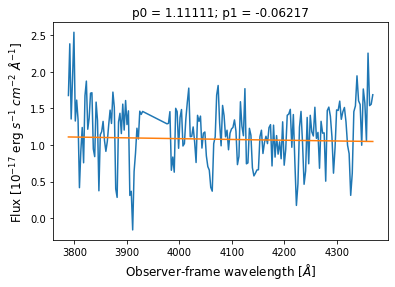

In [26]:
#-- Let's first fit a single continuum and plot it

pixels = list(data.keys())
forest = data[pixels[0]][4]
forest.cont_fit()

plt.figure()
plt.plot(10**forest.log_lambda, forest.flux)
plt.plot(10**forest.log_lambda, forest.cont)
plt.title(f'p0 = {forest.p0:.5f}; p1 = {forest.p1:.5f}')
plt.ylabel(r'Flux [$10^{-17}$ erg $s^{-1}$ $cm^{-2}$ $\AA^{-1}$]', fontsize=12)
plt.xlabel(r'Observer-frame wavelength [$\AA$]', fontsize=12)


### Fit all forests once and compute/plot average quantities

In [27]:
#-- Loop over all forests and fit them
import time

def fit_all_continua():
    t0 = time.time()
    for healpix in data:
        for forest in data[healpix]:
            forest.cont_fit()
    t1 = time.time()
    print(f'Time elapsed fitting all continua: {(t1-t0)/60:.2f} minutes')


In [28]:
fit_all_continua()

Time elapsed fitting all continua: 0.36 minutes


In [29]:
#-- Compute average quantities and update their respective interpolators

#-- Update mean continuum
log_lambda_rest_frame, mean_cont, mean_cont_weight = prep_del.compute_mean_cont(data)

w = mean_cont_weight > 0.
log_lambda_rest_frame = log_lambda_rest_frame[w]
mean_cont = mean_cont[w]

mean_cont_old = Forest.get_mean_cont(log_lambda_rest_frame)

Forest.get_mean_cont = interp1d(log_lambda_rest_frame, mean_cont_old * mean_cont, fill_value="extrapolate")

Text(0, 0.5, 'Mean continuum $\\bar{C}(\\lambda_{\\rm RF})$')

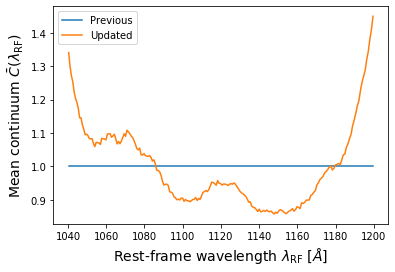

In [30]:
plt.figure()
plt.plot(10**log_lambda_rest_frame, mean_cont_old, label='Previous')
plt.plot(10**log_lambda_rest_frame, mean_cont*mean_cont_old, label='Updated')
plt.legend()
plt.xlabel(r'Rest-frame wavelength $\lambda_{\rm RF}$ [$\AA$]', fontsize=14)
plt.ylabel(r'Mean continuum $\bar{C}(\lambda_{\rm RF})$', fontsize=14)

In [31]:
#-- Update intrinsic variance and correction of pipeline errors

#-- Default values of picca_deltas.py
eta_min = 0.5
eta_max = 1.5
vlss_min = 0.
vlss_max = 0.3

(log_lambda, eta, var_lss, fudge, num_pixels, var_pipe_values,
 var_delta, var2_delta, count, num_qso, chi2_in_bin, error_eta,
 error_var_lss, error_fudge) = prep_del.compute_var_stats(data, (eta_min, eta_max), (vlss_min, vlss_max))



1.4309256765406102 0.062049019624765264 6.239802001761773e-14 43.17478010988351 83626.0 0.01099033679137773 0.0017753455316994009 2.8975921250398607e-06
1.3735305844778254 0.06138220903600387 9.312312145015448e-07 86.81325612303152 125422.0 0.009762571045315416 0.0014109420991070612 1.6092464558147607e-05
1.361534831514943 0.06598875950565318 2.294091619672346e-05 66.85032700898579 135118.0 0.010150498665566166 0.0011097546197021482 9.296963202733651e-06
1.3160405536313504 0.07522991561605685 1.881251069887596e-05 79.91958651916933 129192.0 0.011199818097924252 0.0010079700949874731 6.17353125180693e-06
1.2512324663671688 0.08836686588017066 1.0981238369228788e-05 101.8072743333809 61470.0 0.017891974634565044 0.0018114194218778051 1.1079987821455532e-05
1.2630124956659003 0.08958533530471242 2.0710363417394685e-05 118.47550293813585 118986.0 0.012305857680966814 0.001209365366956601 8.010014835392436e-06
1.1944002380237357 0.09972780260854681 1.604602558433863e-05 130.26345192347807 1

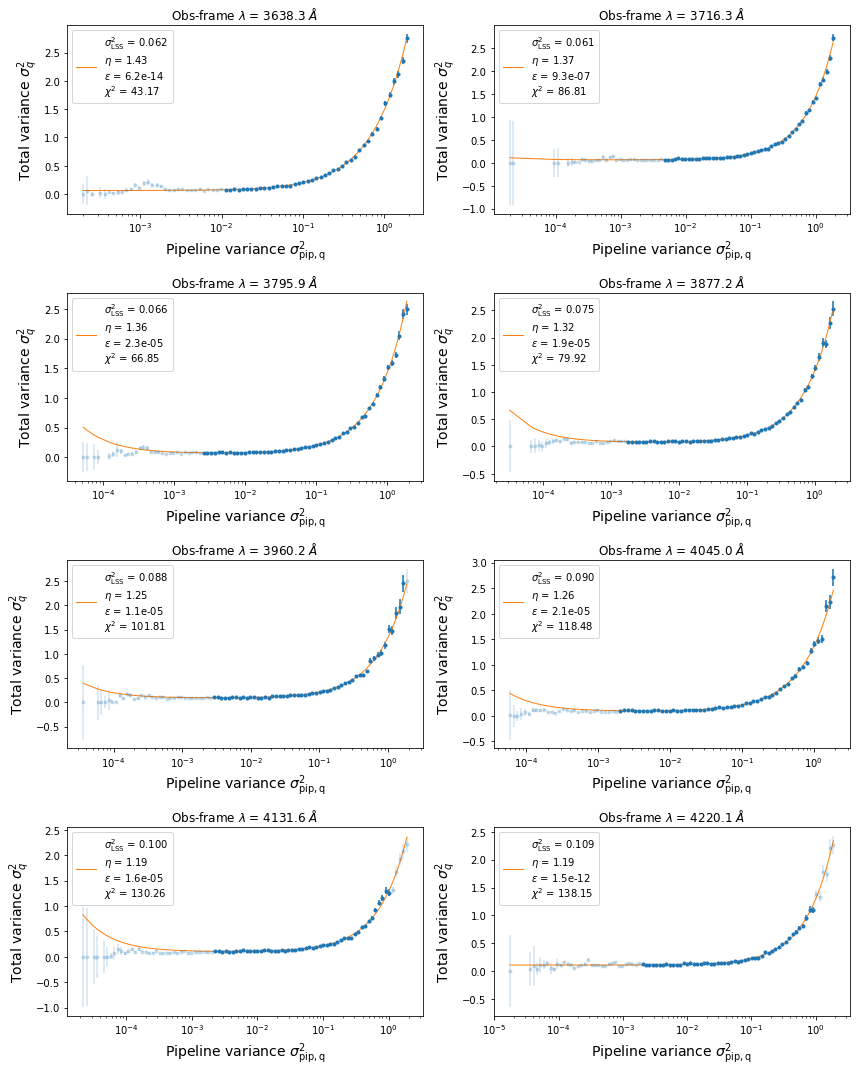

In [32]:
#-- Plot the variance pipeline versus total variance with their best-fit model

def var_model(var_pipe, vlss, eta_pipe, fudge_pipe):
    return eta_pipe * var_pipe + vlss + fudge_pipe / var_pipe

f, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))
axs = np.ravel(axs)
for i in range(len(axs)):
    ax = axs[i]
    #-- The fit of var_lss, eta and fudge only uses pixels where num_qso>100
    #-- but the model is applied to all pixels (need to check the impact of this!)
    w0 = (count[i] > 0) 
    w1 = (count[i] > 0) & (num_qso[i] > 100)

    ax.errorbar(var_pipe_values[w0], var_delta[i][w0], np.sqrt(var2_delta[i][w0]), fmt='.', color='C0', alpha=0.2 )
    ax.errorbar(var_pipe_values[w1], var_delta[i][w1], np.sqrt(var2_delta[i][w1]), fmt='.', color='C0')
    model = var_model(var_pipe_values, var_lss[i], eta[i], fudge[i])
    
    chi2 = np.sum( (var_delta[i][w1]-model[w1])**2/var2_delta[i][w1])
    ax.plot(var_pipe_values[w0], model[w0], color='C1', lw=1,
            label=r'$\sigma_{\rm LSS}^2$ = '+f'{var_lss[i]:.3f} \n'+
                  r'$\eta$ = '+f'{eta[i]:.2f} \n'+
                  r'$\epsilon$ = '+f'{fudge[i]:.1e} \n'+
                  r'$\chi^2$ = '+f'{chi2_in_bin[i]:.2f}')
    ax.set_xscale('log')
    ax.set_xlabel(r'Pipeline variance $\sigma_{\rm pip, q}^2$', fontsize=14)
    ax.set_ylabel(r'Total variance $\sigma_{q}^2$', fontsize=14)
    ax.set_title(r'Obs-frame $\lambda$ = '+f'{10**log_lambda[i]:.1f}'+r' $\AA$')
    ax.legend()
plt.tight_layout()

In [33]:
#-- Updating interpolator before new iteration of continuum fitting

w = num_pixels > 0
Forest.get_eta     = interp1d(log_lambda[w], eta[w],     fill_value="extrapolate", kind="nearest")
Forest.get_var_lss = interp1d(log_lambda[w], var_lss[w], fill_value="extrapolate", kind="nearest")
Forest.get_fudge   = interp1d(log_lambda[w], fudge[w],   fill_value="extrapolate", kind="nearest")

### Perform iterative fit multiple times, updating average quantities

In [34]:
#-- Run few iterations of continuum fitting
num_iterations = 4

for iteration in range(num_iterations):
    print('Iteration ', iteration)
    fit_all_continua()
    
    if iteration < num_iterations - 1:
        
        #-- Update mean continuum
        
        log_lambda_rest_frame, mean_cont, mean_cont_weight = prep_del.compute_mean_cont(data)
        w = mean_cont_weight > 0.
        log_lambda_rest_frame = log_lambda_rest_frame[w]
        mean_cont = mean_cont[w]
        mean_cont_old = Forest.get_mean_cont(log_lambda_rest_frame)
        Forest.get_mean_cont = interp1d(log_lambda_rest_frame, mean_cont_old * mean_cont, fill_value="extrapolate")

        #-- Update intrinsic variance and correction of pipeline errors

        (log_lambda, eta, var_lss, fudge, num_pixels, var_pipe_values,
         var_delta, var2_delta, count, num_qso, chi2_in_bin, error_eta,
         error_var_lss, error_fudge) = prep_del.compute_var_stats(data, (eta_min, eta_max), (vlss_min, vlss_max))
        w = num_pixels > 0
        Forest.get_eta     = interp1d(log_lambda[w], eta[w],     fill_value="extrapolate", kind="nearest")
        Forest.get_var_lss = interp1d(log_lambda[w], var_lss[w], fill_value="extrapolate", kind="nearest")
        Forest.get_fudge   = interp1d(log_lambda[w], fudge[w],   fill_value="extrapolate", kind="nearest")
        

Iteration  0
Time elapsed fitting all continua: 0.34 minutes
1.4354208380148459 0.04089676242976502 7.492786834117915e-12 45.577524612540735 86720.0 0.010113593710052604 0.0011961299506877618 1.8415913745329418e-06
1.373361581690969 0.044210327480188445 3.138589358187789e-05 61.676835859450875 126010.0 0.009405112617788314 0.0012070642630811028 1.3296502907688812e-05
1.3660322607670259 0.04726605513834139 3.6104731470598446e-05 85.79449553142537 135553.0 0.00973879594658067 0.0009734677397999561 8.150327668900971e-06
1.3322242741855792 0.05129114237020839 2.0432242723152297e-05 63.57268931673335 129762.0 0.01046255280344377 0.000827559850993722 4.376626224358342e-06
1.2716878662571083 0.0572301605851446 1.6285339559109225e-05 84.87422642731345 61631.0 0.015953686110300458 0.0012606293276414687 7.428554541130879e-06
1.268506158417088 0.061008405709887664 1.9013061833637642e-05 83.41878649478114 118950.0 0.011269887954923452 0.0008844049582147386 4.507899558397804e-06
1.2226686557004434 

### Plotting histograms of continuum parameters

Continuum fits can fail for two reasons: 
- minimizer didn't converge
- continuum is negative

If one of these happens, this information is stored in forest.bad_cont and the parameters p0 and p1 of the fit are set to zero. 


Text(0.5, 0, 'Continuum parameter $p_1$')

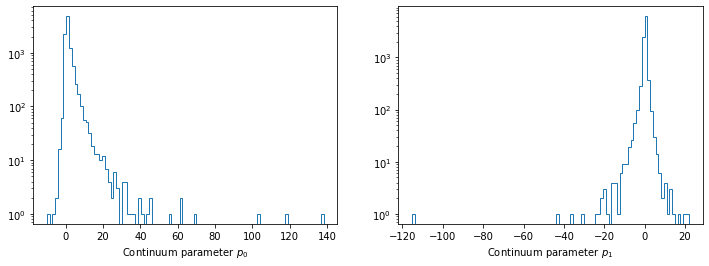

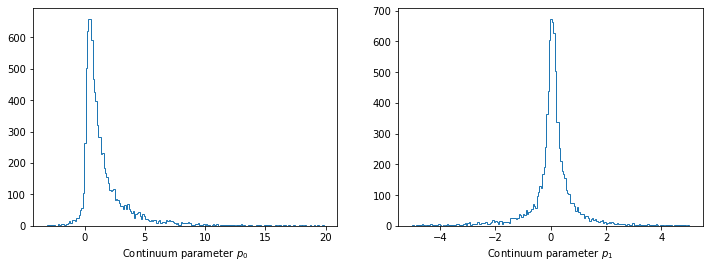

In [35]:
#-- Histogram of best-fit continuum parameters
tab_cont = get_metadata(data)
#w = (tab_cont['p0']>0) & (tab_cont['p0']< 40)
plt.figure(figsize=(12, 4))
plt.subplot(121)
_=plt.hist(tab_cont['p0'], bins=100, histtype='step')
plt.yscale('log')
plt.xlabel(r'Continuum parameter $p_0$')
plt.subplot(122)
_=plt.hist(tab_cont['p1'], bins=100, histtype='step')
plt.xlabel(r'Continuum parameter $p_1$')
plt.yscale('log')

w = (np.abs(tab_cont['p1'])<5) & (tab_cont['p0']< 20) & (tab_cont['p0']!=0)
plt.figure(figsize=(12, 4))
plt.subplot(121)
_=plt.hist(tab_cont['p0'][w], bins=200, histtype='step')
plt.xlabel(r'Continuum parameter $p_0$')
plt.subplot(122)
_=plt.hist(tab_cont['p1'][w], bins=200, histtype='step')
plt.xlabel(r'Continuum parameter $p_1$')


### Plotting final parameters of variance (var_lss, eta, fudge)

Text(0.5, 0, 'Obs-frame wavelength [$\\AA$]')

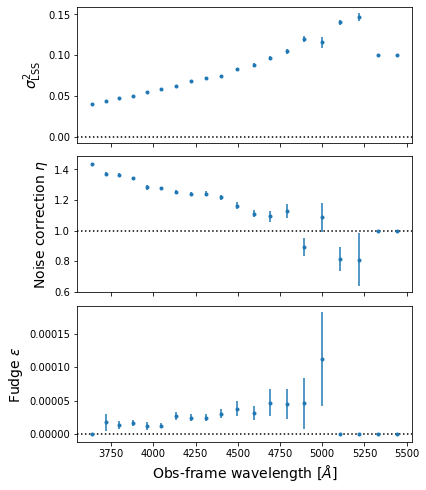

In [36]:
f, axs = plt.subplots(nrows=3, figsize=(6, 8), sharex=True)
f.subplots_adjust(hspace=0.1)
axs[0].errorbar(10**log_lambda, var_lss, error_var_lss, fmt='.')
axs[0].axhline(0, color='k', ls=':')
axs[1].errorbar(10**log_lambda, eta, error_eta, fmt='.')
axs[1].axhline(1, color='k', ls=':')
axs[2].errorbar(10**log_lambda, fudge, error_fudge, fmt='.')
axs[2].axhline(0, color='k', ls=':')
axs[0].set_ylabel(r'$\sigma_{\rm LSS}^2$', fontsize=14)
axs[1].set_ylabel(r'Noise correction $\eta$', fontsize=14)
axs[2].set_ylabel(r'Fudge $\epsilon$', fontsize=14)
axs[2].set_xlabel(r'Obs-frame wavelength [$\AA$]', fontsize=14)

In [37]:
#-- Compute average delta

stack_log_lambda, stack_delta, stack_weight = prep_del.stack(data)
w = stack_weight > 0
get_stack_delta = interp1d(stack_log_lambda[w > 0.],
                           stack_delta[stack_weight > 0.],
                           kind="nearest",
                           fill_value="extrapolate")

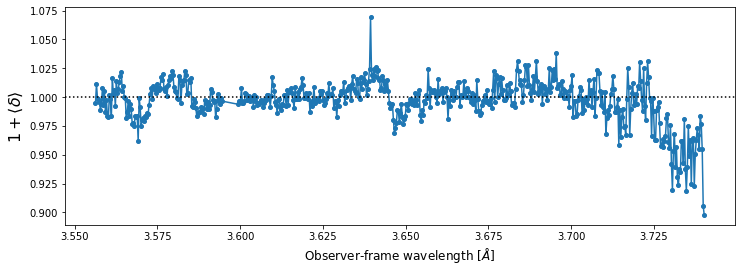

In [38]:
#-- Plot the average delta

plt.figure(figsize=(12, 4))
plt.plot(stack_log_lambda[w], stack_delta[w], 'o-', ms=4)
plt.xlabel(r'Observer-frame wavelength [$\AA$]', fontsize=12)
plt.ylabel(r'$1+\langle \delta \rangle $', fontsize=16)
plt.axhline(1, color='k', ls=':')

## 9) Writting output files 

First we export to FITS files the average quantities into `delta_attributes.fits.gz`.


In [39]:
#-- Export average quantities to FITS format

import fitsio

os.makedirs('Delta_LYA_S82', exist_ok=True)
iter_out = 'Delta_LYA_S82/delta_attributes.fits.gz'

results = fitsio.FITS(iter_out, 'rw', clobber=True)
header = {}
header["NSIDE"] = nside
header["PIXORDER"] = healpy_pix_ordering
header["FITORDER"] = 1
results.write([stack_log_lambda, stack_delta, stack_weight], 
              names=['loglam', 'stack', 'weight'],
              header=header,
              extname='STACK')
results.write([log_lambda, eta, var_lss, fudge, num_pixels],
              names=['loglam', 'eta', 'var_lss', 'fudge', 'nb_pixels'],
              extname='WEIGHT')
results.write([log_lambda_rest_frame,
               Forest.get_mean_cont(log_lambda_rest_frame), 
               mean_cont_weight],
              names=['loglam_rest', 'mean_cont', 'weight'],
              extname='CONT')
var_pipe_values = np.broadcast_to(var_pipe_values.reshape(1, -1),
                                  var_delta.shape)
results.write(
    [var_pipe_values, var_delta, var2_delta, count, num_qso, chi2_in_bin],
    names=['var_pipe', 'var_del', 'var2_del', 'count', 'nqsos', 'chi2'],
    extname='VAR')
results.close()

The "deltas", i.e., the flux contrast values, are exported into FITS files, one file per Healpix pixel.  

In [40]:
#-- Compute deltas and format them
use_mock_continuum = False

deltas = {}
for healpix in sorted(data.keys()):
    deltas[healpix] = []
    for forest in data[healpix]:
        if forest.bad_cont is None:
            d = Delta.from_forest(forest, 
                          get_stack_delta, Forest.get_var_lss,
                          Forest.get_eta, Forest.get_fudge,
                          use_mock_continuum)
            deltas[healpix].append(d)


In [41]:
#-- Export deltas into FITS files

out_dir = 'Delta_LYA_S82/Delta'
os.makedirs(out_dir, exist_ok=True)

for healpix in sorted(deltas.keys()):
    if len(deltas[healpix]) == 0:
        continue
        
    results = fitsio.FITS(out_dir + f"/delta-{healpix}.fits.gz", 'rw', clobber=True)
    for delta in deltas[healpix]:
        header = [
            {
                'name': 'RA',
                'value': delta.ra,
                'comment': 'Right Ascension [rad]'
            },
            {
                'name': 'DEC',
                'value': delta.dec,
                'comment': 'Declination [rad]'
            },
            {
                'name': 'Z',
                'value': delta.z_qso,
                'comment': 'Redshift'
            },
            {
                'name':
                    'PMF',
                'value':
                    '{}-{}-{}'.format(delta.plate, delta.mjd,
                                      delta.fiberid)
            },
            {
                'name': 'THING_ID',
                'value': delta.thingid,
                'comment': 'Object identification'
            },
            {
                'name': 'PLATE',
                'value': delta.plate
            },
            {
                'name': 'MJD',
                'value': delta.mjd,
                'comment': 'Modified Julian date'
            },
            {
                'name': 'FIBERID',
                'value': delta.fiberid
            },
            {
                'name': 'ORDER',
                'value': delta.order,
                'comment': 'Order of the continuum fit'
            },
        ]

        cols = [delta.log_lambda, delta.delta, delta.weights, delta.cont]
        names = ['LOGLAM', 'DELTA', 'WEIGHT', 'CONT']
        units = ['log Angstrom', '', '', '']
        comments = ['Log lambda', 'Delta field', 'Pixel weights', 'Continuum']

        results.write(cols,
                      names=names,
                      header=header,
                      comment=comments,
                      units=units,
                      extname=str(delta.thingid))

    results.close()

## Well done! 

The delta files should be stored in `Delta_LYA_S82/Delta`. 

These are the input for the following methods :
- `picca_cf.py` : auto-correlation function or cross-correlation function with intensity tracer
- `picca_dmat.py` : distortion matrix of the above
- `picca_metal_dmat.py`: metal matrix of the above
- `picca_xcf.py` : cross-correlation function with discrete tracer
- `picca_dmat.py` : distortion matrix of the above
- `picca_metal_dmat.py`: metal matrix of the above